In [56]:


%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchaudio
print(torch.__version__)
print(torchaudio.__version__)

from src import load_music as load

plt.rcParams['figure.figsize'] = (17, 5)

1.10.1+cu113
0.10.1+cu113


In [34]:
AUDIO_DIR = './fma/fma_small/fma_small'
GENRES = [
    "Electronic",
    "Experimental",
    "Folk",
    "Hip-Hop",
    "Instrumental",
    "International",
    "Pop",
    "Rock",
]  # Length 8
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [50]:
class FmaLoader(Dataset):
    """
    :param split: must be either "training", "validation" or "test"; anything else and you get an empty dataset
    :param subset: "small" by default
    """
    def __init__(self, audio_root, tracks_file, split, blacklist = [98565, 98567, 98569, 99134, 108925, 133297, 17631, 17632,17633,17634,17635,17636,17637,29350,29351,29355,54568,54576,54578,55783], subset="small"):
        self.tracks = load.load_meta(tracks_file)
        self.audio_root = audio_root
        self.subset = self.tracks['set','subset'] <= subset
        self.subset[blacklist] = False
        self.split = self.tracks['set', 'split'] == split
        self.rows = self.tracks.index[self.subset & self.split]
    def __len__(self):
        return len(self.rows)
    def __getitem__(self, item):
        label = self.tracks['track', 'genre_top'].loc[self.rows[item]]
        # We ignore the sample rate of the song, the model can choose that for itself
        waveform, _ = torchaudio.load(load.get_audio_path(self.audio_root, self.rows[item]), num_frames=44100*29)
        mono_wv = waveform.mean(0)
        return mono_wv, GENRES.index(label)

In [51]:
train_dataloader = DataLoader(dataset=FmaLoader(audio_root=AUDIO_DIR, tracks_file="./fma/fma_metadata/fma_metadata/tracks.csv", split="training"), batch_size=32, shuffle=True, pin_memory=True)
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
train_wv = train_features[0].squeeze()
train_lbl = train_labels[0]

Feature batch shape: torch.Size([32, 1278900])
Labels batch shape: torch.Size([32])


In [52]:
val_dataloader = DataLoader(dataset=FmaLoader(audio_root=AUDIO_DIR, tracks_file="./fma/fma_metadata/fma_metadata/tracks.csv", split="validation"), batch_size=32, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(dataset=FmaLoader(audio_root=AUDIO_DIR, tracks_file="./fma/fma_metadata/fma_metadata/tracks.csv", split="test"), batch_size=32, shuffle=True, pin_memory=True)

In [6]:
class TempConv(nn.Module):
    def __init__(self, input_channels, output_channels, shape=4, padding=2, pooling=4, dropout=0.1):
        super(TempConv, self).__init__()
        self.conv = nn.Conv1d(input_channels, output_channels, shape, padding=padding, bias=False)
        self.bn = nn.BatchNorm1d(output_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(pooling)
        self.dropout = nn.Dropout(dropout)

    def forward(self, wav):
        out = self.conv(wav)
        out = self.bn(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        return out

In [37]:
class Gramophone(nn.Module):
    def __init__(self, num_channels=256,
                 sample_rate=44100,
                 n_fft=2048,
                 f_min=0.0,
                 f_max=11025.0,
                 num_mels=128,
                 num_classes=8):
        super(Gramophone, self).__init__()

        # mel spectrogram
        self.melspec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
                                                            n_fft=n_fft,
                                                            f_min=f_min,
                                                            f_max=f_max,
                                                            n_mels=num_mels)
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB()
        self.input_bn = nn.BatchNorm1d(128)

        # convolutional layers
        self.layer1 = TempConv(128, num_channels, pooling=5)
        self.layer2 = TempConv(num_channels, num_channels, pooling=5)
        self.layer3 = TempConv(num_channels, num_channels * 2, pooling=5)
        self.layer4 = TempConv(num_channels * 2, num_channels * 2, pooling=5)
        self.ap = nn.AdaptiveMaxPool1d(1)

        # dense layers
        self.dense1 = nn.Linear(num_channels * 2, num_channels * 4)
        self.dense_bn = nn.BatchNorm1d(num_channels * 4)
        self.dense2 = nn.Linear(num_channels * 4, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, wav):
        # input Preprocessing
        #print(wav.device)
        out = self.melspec(wav)
        out = self.amplitude_to_db(out)

        # input batch normalization
        #print(out.shape)
        out = self.input_bn(out)

        # convolutional layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        #print(out.shape)
        out = self.ap(out)
        #print(out.shape)

        # reshape. (batch_size, num_channels, 1, 1) -> (batch_size, num_channels)
        out = out.reshape(len(out), -1)

        # dense layers
        out = self.dense1(out)
        out = self.dense_bn(out)
        #print(out.shape)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.dense2(out)

        return out

In [38]:
cnn = Gramophone().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
num_epochs = 10
patience = 20

In [53]:
# import EarlyStopping
from pytorchtools import EarlyStopping
def train_model(model, batch_size, patience, n_epochs):

    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_dataloader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            data = data.to(device)
            target = target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = loss_function(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in val_dataloader:
            data = data.to(device)
            target = target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = loss_function(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(n_epochs))

        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')

        print(print_msg)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [54]:
torch.backends.cudnn.benchmark = True
model, train_loss, valid_loss = train_model(cnn, 32, patience, num_epochs)

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0

In [60]:
# Load the best model
#S = model #torch.load('checkpoint')
#model.load_state_dict(S)
print('loaded!')

# Run evaluation
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for wav, genre_index in test_dataloader:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        # reshape and aggregate chunk-level predictions
        c, t = wav.size()
        logits = model(wav.view(-1, t))
        _, pred = torch.max(logits.data, 1)

        # append labels and predictions
        y_true.extend(genre_index.tolist())
        y_pred.extend(pred.tolist())

loaded!
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0


Accuracy: 0.4168


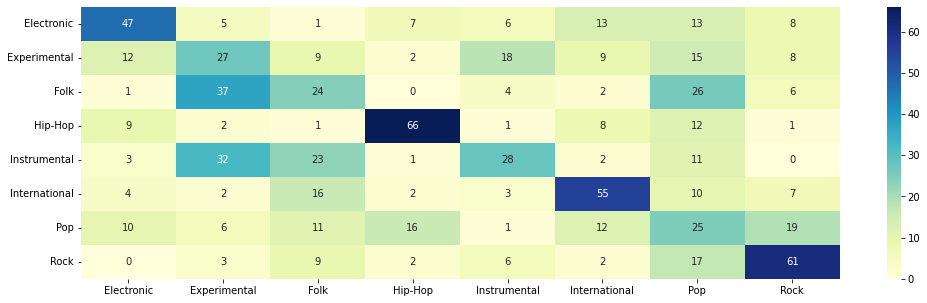

In [62]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, xticklabels=GENRES, yticklabels=GENRES, cmap='YlGnBu')
print('Accuracy: %.4f' % accuracy)